In [128]:
#Importing all my stuff
import pandas as pd
import numpy as np
import hvplot.pandas
from dataprep.clean import clean_country
import fuzzywuzzy
from fuzzywuzzy import process, fuzz
import requests
import datetime as dt
import time
import pycountry
from countryinfo import CountryInfo
import re
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dataprep.clean import clean_date
from mpl_toolkits.basemap import Basemap
import hvplot.pandas
from plottable import Table
weather_api_key = "a8035cf966e04b4612afafe30e26e55a"
geoapify_key = "a2eb724159ed4830944bd40a55611baa"

In [3]:
#Creating a function that will parse through countries and determine if they are in the northern or southern hemisphere

def country_hem(col):
    hem_lst = []
    for row in col:
        try:
            country = CountryInfo(row)
        except AttributeError:
            row = 'x'
            
   
        try:
            pos = country.latlng()
        except KeyError:
            pos = (0,0)
    
        if pos[0] > 0:
            temp_row = 1
            
        elif pos[0] < 0:
            temp_row = 0
            
        else:
            temp_row = 3
            
    
        hem_lst.append(temp_row)
    
    return hem_lst   

# def country_hem(col):
#     hem_lst = []
#     for row in col:
#         try:
#             country = CountryInfo(row)
#         except AttributeError:
#             row = 'x'
#         try:
#             pos = country.latlng()
#         except KeyError:
#             pos = (0,0)
    
#         if pos[0] > 0:
#             temp_row = 1
#         elif pos[0] < 0:
#             temp_row = 0
#         else:
#             temp_row = 3
#         hem_lst.append(temp_row)
#     return hem_lst 

In [4]:
#Bringing in the file
file = "attacks.csv"
#Readin the file
df = pd.read_csv(file, encoding="cp1252")
#Renaming the columns to make them better for me
df.columns = [i.lower().replace(" ", "_") for i in df.columns]
df = df.rename(columns = {"fatal_(y/n)" : "fatal", 'investigator_or_source' : "investigator", 'sex_' : "sex"
                         , 'species_' : "species"})
#Getting rid of the rows where case number is null
df = df[~df["case_number"].isnull()] 
#Getting rid of the row where case number is xx
df = df.loc[df["case_number"]  != "xx", :]
#Getting rid of the row where the case number is 0
df = df.loc[df["case_number"]  != "0", :]
#Dropping useless columns
df = df.drop(columns=['pdf', 'href_formula', 'href', 'case_number.1', 'case_number.2', 'original_order', 'unnamed:_22', 'unnamed:_23', 'case_number']) 
df = df.reset_index()

In [5]:
#Cleaning up countries. This creates a new columne called country_clean (more on that shortly)
df = clean_country(df, "country", fuzzy_dist=1)
#Getting rid of the original dirty country column
df = df.drop(columns=['country'])
#Renaming country_clean
df = df.rename(columns = {"country_clean" : "country"})

C:\Users\Grant\anaconda3\envs\dev\lib\site-packages\dask\dataframe\core.py:7234: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


  0%|                                                                                            | 0/8 [00:00<…

Country Cleaning Report:
	6091 values cleaned (96.67%)
	155 values unable to be parsed (2.46%), set to NaN
Result contains 6096 (96.75%) values in the correct format and 205 null values (3.25%)


In [6]:
#This will create a new column called month. Which is created from the date column.
month_list = []
for row in df['date']:
    month_row = ''.join(re.findall('\-[A-Za-z]{3}\-',row)).lower()
    month_row = re.sub('\-','',month_row)
    if month_row == '':
        month_row = np.nan
    month_list.append(month_row)
df['month'] = month_list

In [7]:
#Cleaning up incorrect month data.
df['month'] = df['month'].replace({'marmar': 'mar', 'augaug': 'aug', 'sepsep': 'sep', 'janjan': 'jan', 'novnov': 'nov'})
df['month'].fillna('Unknown', inplace=True)
df.head()

,index,date,year,type,area,location,activity,name,sex,age,injury,fatal,time,species,investigator,country,month
0,0,25-Jun-18,2018.0,Boating,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,"No injury to occupant, outrigger canoe and pad...",N,18h00,White shark,"R. Collier, GSAF",United States,jun
1,1,18-Jun-18,2018.0,Unprovoked,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,11,Minor injury to left thigh,N,14h00 -15h00,NaN,"K.McMurray, TrackingSharks.com",United States,jun
2,2,9-Jun-18,2018.0,Invalid,Hawaii,"Habush, Oahu",Surfing,John Denges,M,48,Injury to left lower leg from surfboard skeg,N,07h45,NaN,"K.McMurray, TrackingSharks.com",United States,jun
3,3,8-Jun-18,2018.0,Unprovoked,New South Wales,Arrawarra Headland,Surfing,male,M,NaN,Minor injury to lower leg,N,NaN,2 m shark,"B. Myatt, GSAF",Australia,jun
4,4,4-Jun-18,2018.0,Provoked,Colima,La Ticla,Free diving,Gustavo Ramos,M,NaN,Lacerations to leg & hand shark PROVOKED INCIDENT,N,NaN,"Tiger shark, 3m",A .Kipper,Mexico,jun


In [8]:
#Creating a new column that utilizes the country_hem function from above.
df['hemisphere'] = country_hem(df['country']) 
df.head(2)

,index,date,year,type,area,location,activity,name,sex,age,injury,fatal,time,species,investigator,country,month,hemisphere
0,0,25-Jun-18,2018.0,Boating,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,"No injury to occupant, outrigger canoe and pad...",N,18h00,White shark,"R. Collier, GSAF",United States,jun,1
1,1,18-Jun-18,2018.0,Unprovoked,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,11,Minor injury to left thigh,N,14h00 -15h00,NaN,"K.McMurray, TrackingSharks.com",United States,jun,1


In [10]:
#Creating dictionaries for seasons for northern and southern hemispheres.
north_seasons = {'spring': ['mar', 'apr', 'may'],
                 'summer': ['jun', 'jul', 'aug'],
                 'fall': ['sep', 'oct', 'nov'],
                 'winter': ['dec', 'jan', 'feb']}

south_seasons = {'spring': ['sep', 'oct', 'nov'],
                 'summer': ['dec', 'jan', 'feb'],
                 'fall': ['mar', 'apr', 'may'],
                 'winter': ['jun', 'jul', 'aug']}

In [11]:
#Running through the each row to apply season with the dictionaries created perviously.
seasonz = []
for row in df.index:
    if df.at[row, 'hemisphere'] == 1:
        if df.at[row, 'month'] in north_seasons['spring']:
            seasonz.append('spring')
        elif df.at[row, 'month'] in north_seasons['summer']:
            seasonz.append('summer')
        elif df.at[row, 'month'] in north_seasons['fall']:
            seasonz.append('fall')
        elif df.at[row, 'month'] in north_seasons['winter']:
            seasonz.append('winter')
        else:
            seasonz.append('Unknown')
    elif df.at[row, 'hemisphere'] == 0:
        if df.at[row, 'month'] in south_seasons['spring']:
            seasonz.append('spring')
        elif df.at[row, 'month'] in south_seasons['summer']:
            seasonz.append('summer')
        elif df.at[row, 'month'] in south_seasons['fall']:
            seasonz.append('fall')
        elif df.at[row, 'month'] in south_seasons['winter']:
            seasonz.append('winter')
        else:
            seasonz.append('Unknown')
    else:
        seasonz.append('Unknown')
df['seasons'] = seasonz

In [12]:
df.head()

,index,date,year,type,area,location,activity,name,sex,age,injury,fatal,time,species,investigator,country,month,hemisphere,seasons
0,0,25-Jun-18,2018.0,Boating,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,"No injury to occupant, outrigger canoe and pad...",N,18h00,White shark,"R. Collier, GSAF",United States,jun,1,summer
1,1,18-Jun-18,2018.0,Unprovoked,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,11,Minor injury to left thigh,N,14h00 -15h00,NaN,"K.McMurray, TrackingSharks.com",United States,jun,1,summer
2,2,9-Jun-18,2018.0,Invalid,Hawaii,"Habush, Oahu",Surfing,John Denges,M,48,Injury to left lower leg from surfboard skeg,N,07h45,NaN,"K.McMurray, TrackingSharks.com",United States,jun,1,summer
3,3,8-Jun-18,2018.0,Unprovoked,New South Wales,Arrawarra Headland,Surfing,male,M,NaN,Minor injury to lower leg,N,NaN,2 m shark,"B. Myatt, GSAF",Australia,jun,0,winter
4,4,4-Jun-18,2018.0,Provoked,Colima,La Ticla,Free diving,Gustavo Ramos,M,NaN,Lacerations to leg & hand shark PROVOKED INCIDENT,N,NaN,"Tiger shark, 3m",A .Kipper,Mexico,jun,1,summer


In [13]:
df['lat'] = ""
df['lon'] = ""


for index, row in df.iterrows():
    place = row['country']
    try:
        country = CountryInfo(place)
    except AttributeError:
        pass

    try:
        pos = country.latlng()
        df.loc[index, "lat"] = pos[0]
        df.loc[index, "lon"] = pos[1]
    except KeyError:
        pos = (-78,-14)




In [14]:
df.head()

,index,date,year,type,area,location,activity,name,sex,age,...,fatal,time,species,investigator,country,month,hemisphere,seasons,lat,lon
0,0,25-Jun-18,2018.0,Boating,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,...,N,18h00,White shark,"R. Collier, GSAF",United States,jun,1,summer,38,-97
1,1,18-Jun-18,2018.0,Unprovoked,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,11,...,N,14h00 -15h00,NaN,"K.McMurray, TrackingSharks.com",United States,jun,1,summer,38,-97
2,2,9-Jun-18,2018.0,Invalid,Hawaii,"Habush, Oahu",Surfing,John Denges,M,48,...,N,07h45,NaN,"K.McMurray, TrackingSharks.com",United States,jun,1,summer,38,-97
3,3,8-Jun-18,2018.0,Unprovoked,New South Wales,Arrawarra Headland,Surfing,male,M,NaN,...,N,NaN,2 m shark,"B. Myatt, GSAF",Australia,jun,0,winter,-27,133
4,4,4-Jun-18,2018.0,Provoked,Colima,La Ticla,Free diving,Gustavo Ramos,M,NaN,...,N,NaN,"Tiger shark, 3m",A .Kipper,Mexico,jun,1,summer,23,-102


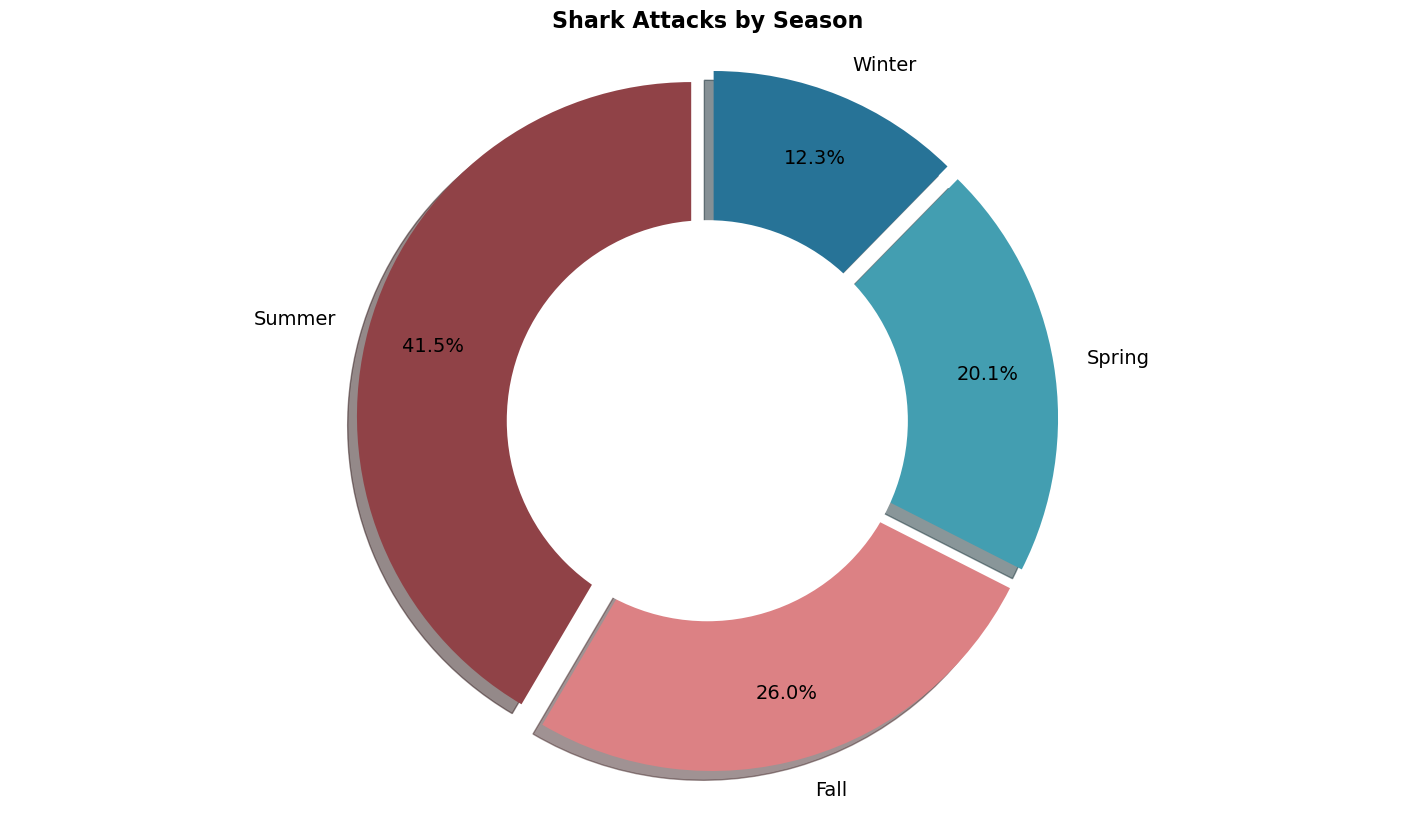

In [143]:
#Grants 

research_question_one_df = df.loc[df["seasons"]  != "Unknown", :]
pies = research_question_one_df['seasons'].unique()
pie_votes = research_question_one_df.groupby('seasons').agg({'seasons':['count']}, axis="columns")
colors = ["#904247","#dc8184","#439eb1","#277397"]
explode = [0.05, 0.05, 0.05, 0.05]

a = research_question_one_df['seasons'].value_counts()
plt.pie(a, explode=explode, labels=["Summer","Fall","Spring","Winter"], colors = colors, autopct="%1.1f%%", shadow=True, 
        startangle=90, pctdistance=0.8, textprops={'fontsize': 14})
center_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Shark Attacks by Season", fontweight="bold", fontsize=16)
plt.axis("equal")
plt.show()

In [144]:
#  World map for summer
# https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/
research_question_two_df = df.loc[df["country"]  != "Unknown", :]
research_question_two_df = research_question_two_df.loc[df["lat"]  != "", :]
research_question_two_df = research_question_two_df.loc[df["lon"]  != "", :]
research_question_two_df = research_question_two_df.loc[df["seasons"]  == "summer", :]
research_question_two_df = research_question_two_df.groupby(['country','lat', 'lon']).agg(n = ("country", "count")).reset_index()
research_question_two_df.sort_values(by=['n'])

,country,lat,lon,n
38,Lebanon,33.833333,35.833333,1
37,Kiribati,1.416667,173.000000,1
27,Iceland,65.000000,-18.000000,1
39,Liberia,6.500000,-9.500000,1
25,Haiti,19.000000,-72.416667,1
...,...,...,...,...
33,Italy,42.833333,12.833333,29
47,New Zealand,-41.000000,174.000000,69
63,South Africa,-29.000000,24.000000,222
2,Australia,-27.000000,133.000000,522


C:\Users\Grant\AppData\Local\Temp\ipykernel_26028\4156921439.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


Text(-175, -62, 'Bubble World Map of Shark Attacks Summer')

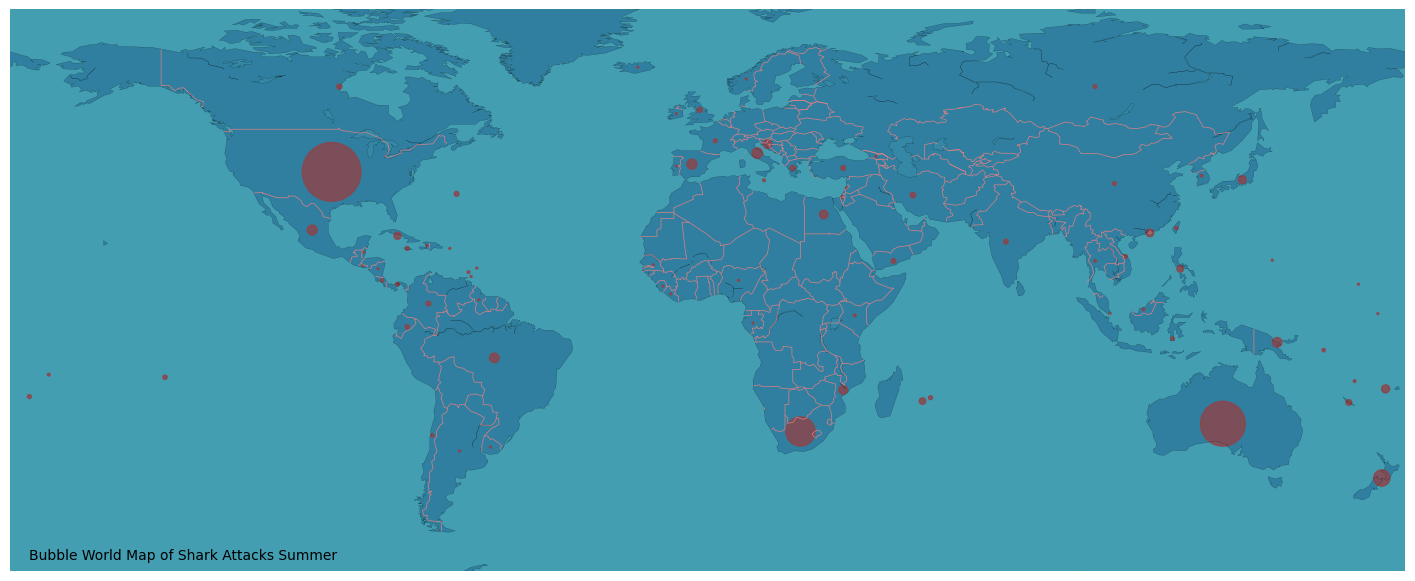

In [145]:
# Set the dimension of the figure Summer
plt.rcParams["figure.figsize"]=18,10;

#Make the background map
m = Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80, projection='cyl')
m.drawmapboundary(fill_color='#439eb1', linewidth=0)
m.fillcontinents(color='#053979', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="black")
m.drawcountries(linewidth=0.5, linestyle='solid', color='#dc8184')


# prepare a color for each point depending on the continent.
research_question_two_df['labels_enc'] = pd.factorize(research_question_two_df['country'])[0]

# Add a point per position
plt.scatter(
    x =research_question_two_df['lon'], 
    y = research_question_two_df['lat'], 
    s=research_question_two_df['n']*2, 
    alpha=.8, 
    c="#904247", 
    cmap="Set1"
)
plt.text( -175, -62,'Bubble World Map of Shark Attacks Summer')

In [146]:
#  World map for fall
# https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/
research_question_two_df = df.loc[df["country"]  != "Unknown", :]
research_question_two_df = research_question_two_df.loc[df["lat"]  != "", :]
research_question_two_df = research_question_two_df.loc[df["lon"]  != "", :]
research_question_two_df = research_question_two_df.loc[df["seasons"]  == "fall", :]
research_question_two_df = research_question_two_df.groupby(['country','lat', 'lon']).agg(n = ("country", "count")).reset_index()
research_question_two_df.sort_values(by=['n'], ascending=False)

,country,lat,lon,n
65,United States,38.000000,-97.000000,597
0,Australia,-27.000000,133.000000,274
56,South Africa,-29.000000,24.000000,134
3,Brazil,-10.000000,-55.000000,32
41,New Zealand,-41.000000,174.000000,28
...,...,...,...,...
35,Martinique,14.666667,-61.000000,1
30,Kenya,1.000000,38.000000,1
20,Haiti,19.000000,-72.416667,1
21,Honduras,15.000000,-86.500000,1


C:\Users\Grant\AppData\Local\Temp\ipykernel_26028\1749707250.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


Text(-175, -62, 'Bubble World Map of Shark Attacks Fall')

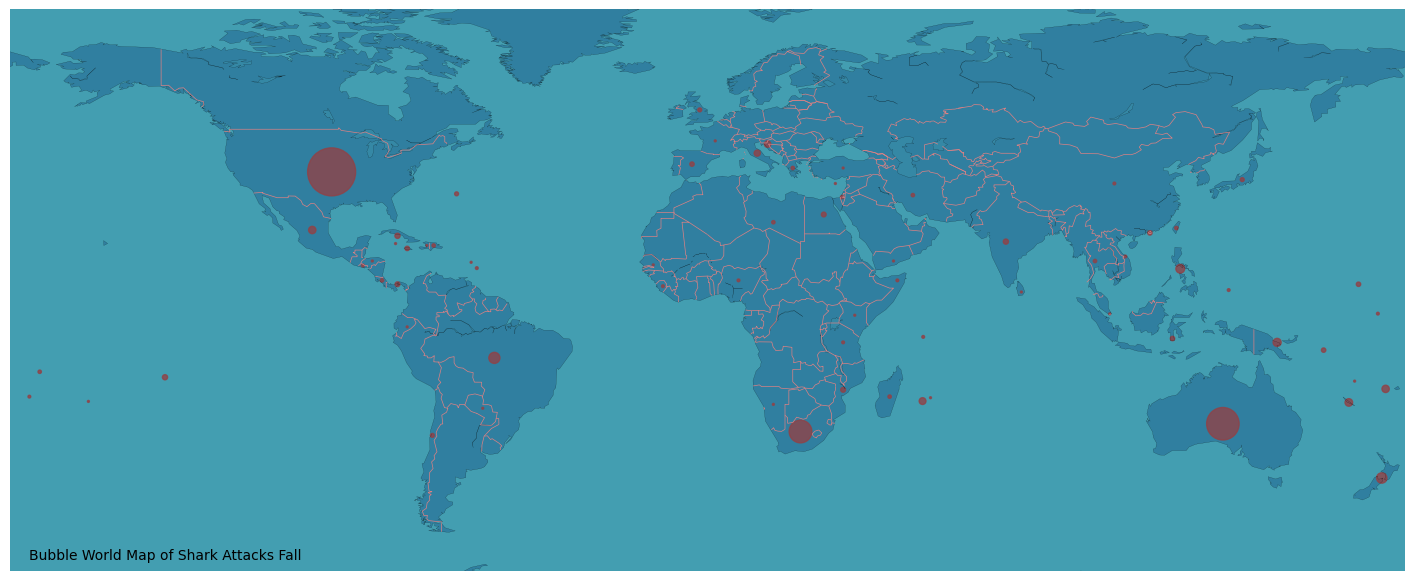

In [147]:
# Set the dimension of the figure Fall
plt.rcParams["figure.figsize"]=18,10;

#Make the background map
m = Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80, projection='cyl')
m.drawmapboundary(fill_color='#439eb1', linewidth=0)
m.fillcontinents(color='#053979', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="black")
m.drawcountries(linewidth=0.5, linestyle='solid', color='#dc8184')

# prepare a color for each point depending on the continent.
research_question_two_df['labels_enc'] = pd.factorize(research_question_two_df['country'])[0]

# Add a point per position
plt.scatter(
    x =research_question_two_df['lon'], 
    y = research_question_two_df['lat'], 
    s=research_question_two_df['n']*2, 
    alpha=.8, 
    c="#904247", 
    cmap="Set1"
)
plt.text( -175, -62,'Bubble World Map of Shark Attacks Fall')

In [148]:
#  World map for spring
# https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/
research_question_two_df = df.loc[df["country"]  != "Unknown", :]
research_question_two_df = research_question_two_df.loc[df["lat"]  != "", :]
research_question_two_df = research_question_two_df.loc[df["lon"]  != "", :]
research_question_two_df = research_question_two_df.loc[df["seasons"]  == "spring", :]
research_question_two_df = research_question_two_df.groupby(['country','lat', 'lon']).agg(n = ("country", "count")).reset_index()
research_question_two_df.sort_values(by=['n'])

,country,lat,lon,n
0,Antigua and Barbuda,17.05,-61.80,1
27,Iraq,33.00,44.00,1
32,Kuwait,29.50,45.75,1
33,Malaysia,2.50,112.50,1
34,Maldives,3.25,73.00,1
...,...,...,...,...
47,Papua New Guinea,-6.00,147.00,21
5,Brazil,-10.00,-55.00,21
57,South Africa,-29.00,24.00,81
1,Australia,-27.00,133.00,275


C:\Users\Grant\AppData\Local\Temp\ipykernel_26028\2298052477.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


Text(-175, -62, 'Bubble World Map of Shark Attacks Spring')

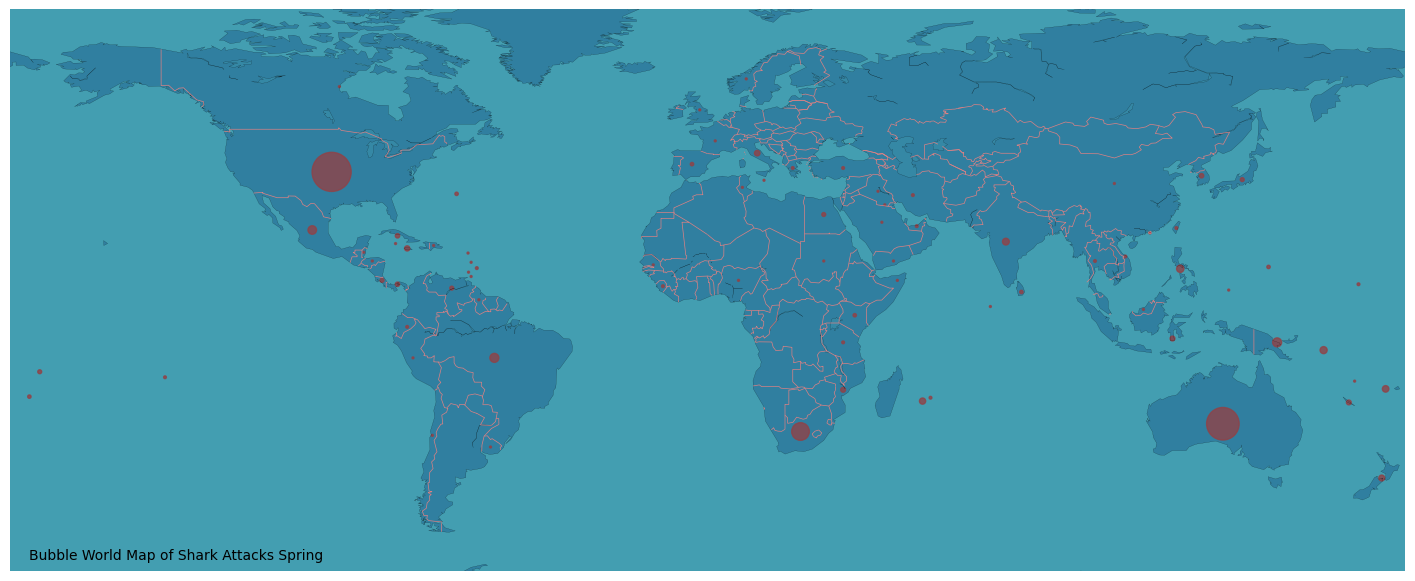

In [149]:
 # Set the dimension of the figure spring
plt.rcParams["figure.figsize"]=18,10;

#Make the background map
m = Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80, projection='cyl')
m.drawmapboundary(fill_color='#439eb1', linewidth=0)
m.fillcontinents(color='#053979', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="black")
m.drawcountries(linewidth=0.5, linestyle='solid', color='#dc8184')

# prepare a color for each point depending on the continent.
research_question_two_df['labels_enc'] = pd.factorize(research_question_two_df['country'])[0]

# Add a point per position
plt.scatter(
    x =research_question_two_df['lon'], 
    y = research_question_two_df['lat'], 
    s=research_question_two_df['n']*2, 
    alpha=.8, 
    c="#904247", 
    cmap="Set1"
)
plt.text( -175, -62,'Bubble World Map of Shark Attacks Spring')

In [150]:
#  World map for winter
# https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/
research_question_two_df = df.loc[df["country"]  != "Unknown", :]
research_question_two_df = research_question_two_df.loc[df["lat"]  != "", :]
research_question_two_df = research_question_two_df.loc[df["lon"]  != "", :]
research_question_two_df = research_question_two_df.loc[df["seasons"]  == "winter", :]
research_question_two_df = research_question_two_df.groupby(['country','lat', 'lon']).agg(n = ("country", "count")).reset_index()
research_question_two_df.sort_values(by=['n'])

,country,lat,lon,n
0,American Samoa,-14.333333,-170.0,1
23,Guinea,11.000000,-10.0,1
24,Honduras,15.000000,-86.5,1
27,Iran,32.000000,53.0,1
28,Iraq,33.000000,44.0,1
...,...,...,...,...
49,Reunion,-21.150000,55.5,19
4,Brazil,-10.000000,-55.0,29
55,South Africa,-29.000000,24.0,87
3,Australia,-27.000000,133.0,158


C:\Users\Grant\AppData\Local\Temp\ipykernel_26028\228056528.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


Text(-175, -62, 'Bubble World Map of Shark Attacks Winter')

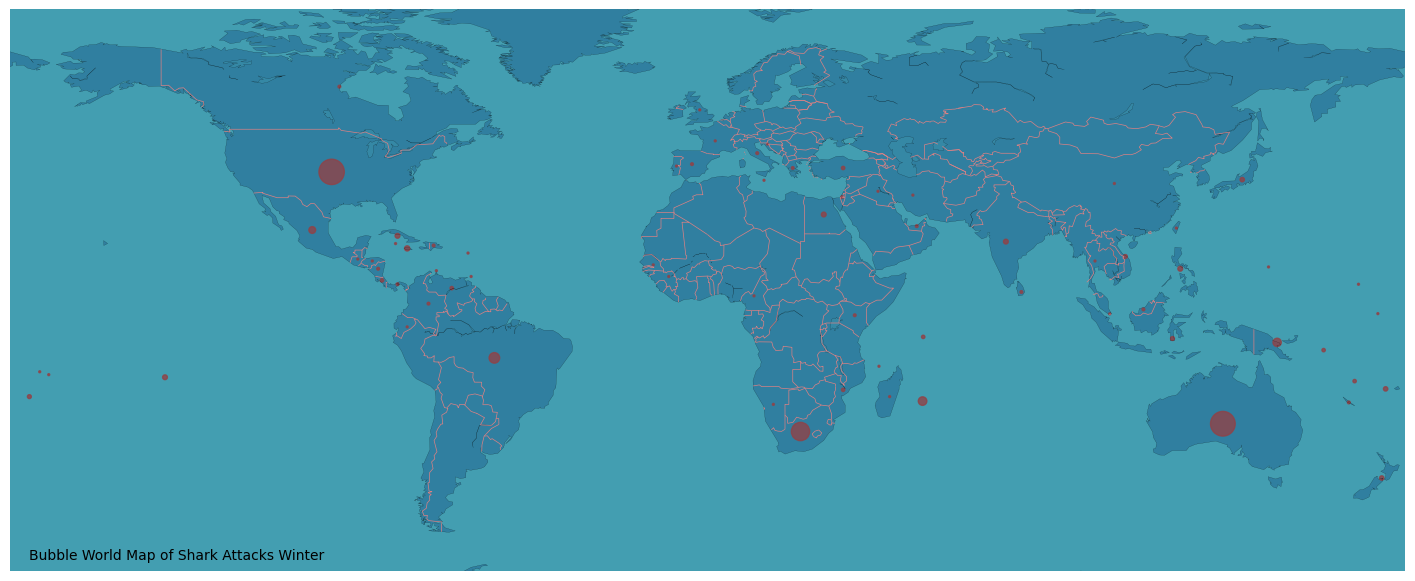

In [151]:
# Set the dimension of the figure winter
plt.rcParams["figure.figsize"]=18,10;

#Make the background map
m = Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80, projection='cyl')
m.drawmapboundary(fill_color='#439eb1', linewidth=0)
m.fillcontinents(color='#053979', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="black")
m.drawcountries(linewidth=0.5, linestyle='solid', color='#dc8184')

# prepare a color for each point depending on the continent.
research_question_two_df['labels_enc'] = pd.factorize(research_question_two_df['country'])[0]

# Add a point per position
plt.scatter(
    x =research_question_two_df['lon'], 
    y = research_question_two_df['lat'], 
    s=research_question_two_df['n']*2, 
    alpha=.8, 
    c="#904247", 
    cmap="Set1"
)
plt.text( -175, -62,'Bubble World Map of Shark Attacks Winter')